## libstempo tutorial: basic functionality

#### Michele Vallisneri, vallis@vallis.org; latest revision: 2016/10/12 for v2.3 revision

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
import sys, math, numpy as N, matplotlib.pyplot as P

Load the libstempo Python extension. It requires a source installation of tempo2, as well as current Python and compiler, and the numpy and Cython packages.

(Both Python 2.7 and 3.4 are supported; this means that in Python 2.7 all returned strings will be unicode strings, while in Python 3 all function arguments should be default unicode strings rather than `bytes`. This should work transparently, although there are limitations to what characters can be passed to tempo2; you should probably restrain yourself to ASCII.

In [3]:
from libstempo.libstempo import *

In [4]:
import libstempo

In [5]:
libstempo.__path__

['/Users/jaellis/Packages/libstempo/libstempo']

In [6]:
import libstempo as T

T.data = T.__path__[0] + '/data/' # example files

In [7]:
print("Python version   :",sys.version.split()[0])
print("libstempo version:",T.__version__)
print("Tempo2 version   :",T.libstempo.tempo2version())

Python version   : 3.8.8
libstempo version: 2.3.5
Tempo2 version   : 2020.11.1


We load a single-pulsar object. Doing this will automatically run the tempo2 fit routine once.

In [60]:
psr = T.tempopulsar(
    parfile=T.data + "/J1909-3744_NANOGrav_dfg+12.par", 
    timfile=T.data + "/J1909-3744_NANOGrav_dfg+12.tim"
)

Let's start simple: what is the name of this pulsar? (You can change it, by the way.)

In [61]:
psr.name

'1909-3744'

Next, let's look at observations: there are `psr.nobs` of them; we can get numpy arrays of the site TOAs [in MJDs] with `psr.stoas`, of the TOA measurement errors [in microseconds] with `psr.toaerrs`, and of the measurement frequencies with `psr.freqs`. These arrays are *views* of the tempo2 data, so you can write to them (but you cannot currently change the number of observations).

In [62]:
psr.nobs

1001

In [63]:
psr.stoas

array([53292.01653553, 53292.04810963, 53355.83359728, ...,
       54641.17334037, 54706.99327092, 54764.83484499], dtype=float128)

In [68]:
psr.toaerrs.min()

0.022

In [65]:
psr.toaerrs

array([1.231, 4.668, 0.453, ..., 0.158, 1.336, 0.316])

In [13]:
psr.freqs

array([1372., 1372., 1372., ...,  884.,  884.,  884.])

By contrast, barycentric TOAs and frequencies are computed on the basis of current pulsar parameters, so you get them by calling `psr` *methods* (with parentheses), and you get a *copy* of the current values. Writing to it has no effect on the tempo2 data.

In [14]:
psr.toas()

array([53292.01663801, 53292.04820909, 53355.82916309, ...,
       54641.1796227 , 54706.99748746, 54764.83381846], dtype=float128)

In [15]:
psr.ssbfreqs()

array([1.37213133e+09, 1.37213155e+09, 1.37204346e+09, ...,
       8.83982927e+08, 8.84066115e+08, 8.84080037e+08])

Residuals (in seconds) are returned by residuals(). The method takes a few options... I'll let its docstring help describe them. libstempo is fully documented in this way (try `help(T.tempopulsar)`). 

In [16]:
help(psr.residuals)

Help on built-in function residuals:

residuals(...) method of libstempo.libstempo.tempopulsar instance
    tempopulsar.residuals(updatebats=True,formresiduals=True,removemean=True)
    
    Returns residuals as a numpy.longdouble array (a copy of current values).
    Will update TOAs/recompute residuals if `updatebats`/`formresiduals` is True
    (default for both). Will remove residual mean if `removemean` is True;
    first residual if `removemean` is 'first'; weighted residual mean
    if `removemean` is 'weighted'.



In [71]:
psr.residuals().min()

-1.9495577521407410551e-05

In [17]:
psr.residuals()

array([-8.90375027e-08,  7.20177874e-06,  1.09278937e-06, ...,
        3.90245100e-07,  1.40247001e-06, -5.17387541e-07], dtype=float128)

We can plot TOAs vs. residuals, but we should first sort the arrays; otherwise the array follow the order in the tim file, which may not be chronological.

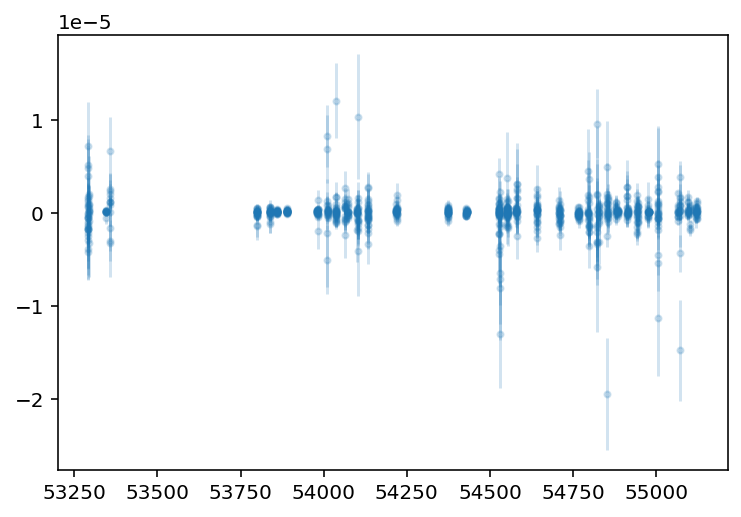

In [18]:
# get sorted array of indices
i = N.argsort(psr.toas())
# use numpy fancy indexing to order residuals 
P.errorbar(psr.toas()[i],psr.residuals()[i],yerr=1e-6*psr.toaerrs[i],fmt='.',alpha=0.2);

We can also see what flags have been set on the observations, and what their values are. The latter returns a numpy vector of strings. *Flags are not currently writable.*

In [73]:
psr.flags()

['fe', 'be', 'B', 'bw', 'tobs', 'pta', 'proc', 'chanid']

In [75]:
psr.flagvals('chanid')

array(['gasp_1372', 'gasp_1372', 'gasp_1372', ..., 'gasp_884', 'gasp_884',
       'gasp_884'], dtype='<U32')

In fact, there's a commodity routine in `libstempo.plot` to plot residuals, taking flags into account.

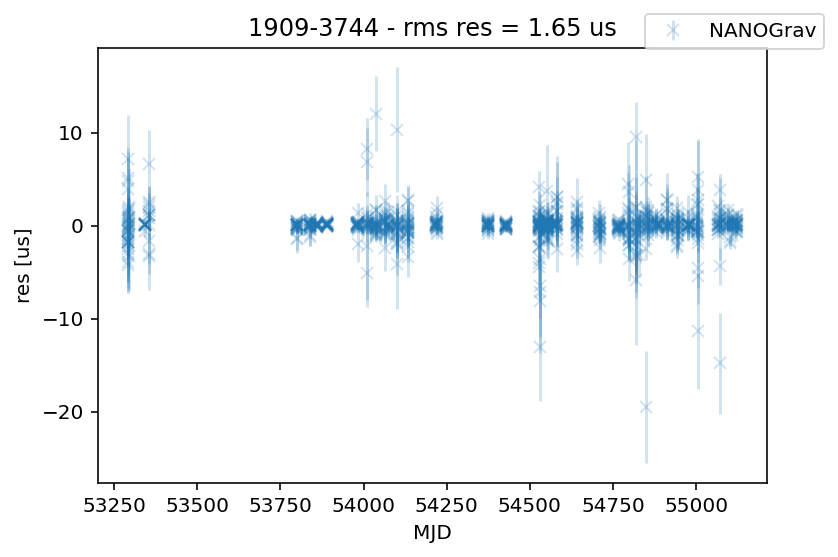

In [21]:
import libstempo.plot as LP

LP.plotres(psr,group='pta',alpha=0.2)

Timing-model parameters can be accessed by using psr as a Python dictionary. Each parameter is a special object with properties `val`, `err` (as well as `fit`, which is true is the parameter is currently being fitted, and `set`, which is true if the parameter was assigned a value).

In [22]:
psr['RAJ'].val, psr['RAJ'].err, psr['RAJ'].fit, psr['RAJ'].set

(5.0169080674060326785, 7.753759525058565179e-10, True, True)

The names of all fitted parameters, of all set parameters, and of *all* parameters are returned by `psr.pars(which='fit')`. We show only the first few.

In [76]:
fitpars = psr.pars() # defaults to fitted parameters
setpars = psr.pars(which='set')
allpars = psr.pars(which='all')

print(len(fitpars),len(setpars),len(allpars))
print(fitpars[:10])

82 158 4487
('RAJ', 'DECJ', 'F0', 'F1', 'PMRA', 'PMDEC', 'PX', 'SINI', 'PB', 'A1')


The number of fitting parameters is psr.ndim.

In [24]:
psr.ndim

82

Changing the parameter values results in different residuals.

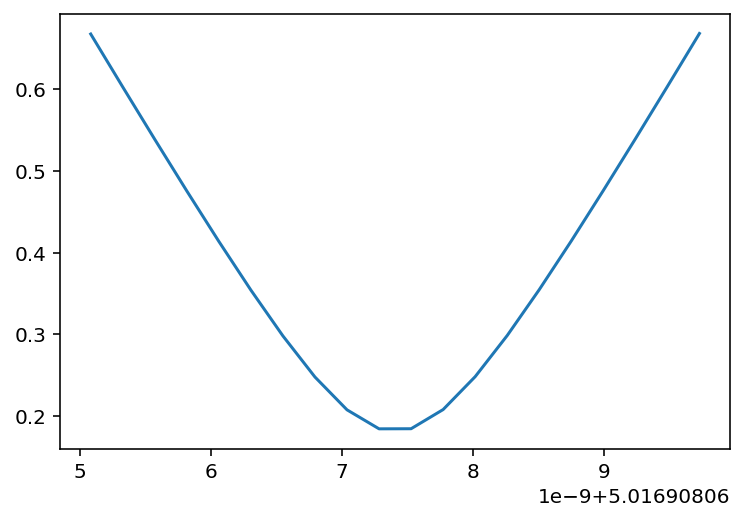

In [25]:
# look +/- 3 sigmas around the current value
x0, dx = psr['RAJ'].val, psr['RAJ'].err
xs = x0 + dx * N.linspace(-3,3,20)         

res = []
for x in xs:
    psr['RAJ'].val = x
    res.append(psr.rms()/1e-6)
psr['RAJ'].val = x0                       # restore the original value

P.plot(xs,res)

We can also call a least-squares fitting routine, which will fit around the current parameter values, replacing them with their new best values. Individual parameters can be included or excluded in the fitting by setting their 'fit' field. (Note: as of version 2.3.0, libstempo provides its own fit, although it does call tempo2 to compute the design matrix.)

In [26]:
psr['DM'].fit

False

In [27]:
psr['DM'].fit = True
print(psr['DM'].val)

10.39468


In [28]:
ret = psr.fit()

<ipython-input-28-9573468db8f6>:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  ret = psr.fit()


In [30]:
print(psr['DM'].val,psr['DM'].err)

12.44929217501132257 2.4420277109658732329


The fit returns a tuple consisting of best-fit vector, standard errors, covariance matrix, and linearized chisq. Note that these vectors and matrix are (ndim+1)- or (ndim+1)x(ndim+1)-dimensional, with the first row/column corresponding to a constant phase offset referenced to the first TOA (even if that point is not used).

The exact chisq can be recomputed by `psr.chisq()` (which evaluates `N.sum(psr.residuals()**2 / (1e-12 * psr.toaerrs**2))`). 

The pulsar parameters can be read in bulk by calling `psr.vals(which='fit')`, which will default to fitted parameters, but can also be given `'all'`, `'set'`, or even a list of parameter names.

In [31]:
fitvals = psr.vals()
print(fitvals)

[ 5.01690807e+00 -6.58640325e-01  3.39315693e+02 -1.61479637e-15
  1.24492922e+01 -9.61134885e+00 -3.55610623e+01  1.09376204e-01
  9.98802510e-01  1.53344945e+00  1.89799103e+00  5.31139506e+04
 -4.23101754e-08 -2.76196797e-07  2.12686298e-01 -4.61493364e-04
 -1.33469060e-03 -1.54959068e-03 -1.56166022e-03 -1.53631872e-03
 -9.14443521e-04 -8.34872184e-04 -8.34769792e-04 -1.28675206e-03
 -1.31237732e-03 -1.77392514e-03 -1.93187424e-03 -1.11677453e-03
 -1.34125578e-03 -1.90583738e-03 -1.94116513e-03 -1.93439054e-03
 -1.83287537e-03 -1.37034067e-03 -1.31187932e-03 -1.50103444e-03
 -1.93739065e-03 -2.12021949e-03 -2.27831135e-03 -2.38561327e-03
 -2.32023428e-03 -2.26177402e-03 -2.11145472e-03 -1.81339103e-03
 -1.52561830e-03 -1.68029389e-03 -2.61732757e-05 -5.22638778e-05
 -7.82207213e-05 -1.03892764e-04 -1.29251007e-04 -1.54430070e-04
 -1.79441398e-04 -2.04096982e-04 -2.28617873e-04 -2.52966254e-04
 -2.77139592e-04 -3.01055318e-04 -3.24722586e-04 -3.48284300e-04
 -3.71647866e-04  9.06449

In [32]:
psr.vals(which=['RAJ','DECJ','PMRA'])

array([ 5.01690807, -0.65864032, -9.61134885], dtype=float128)

To set parameter values in bulk, you give a first argument to `vals`. Or call it with a dictionary. 

In [33]:
psr.vals([5.1,-0.6],which=['RAJ','DECJ','PMRA'])
psr.vals({'PMRA': -9.5})

print(psr.vals(which=['RAJ','DECJ','PMRA']))

# restore original values
psr.vals(fitvals)

[ 5.1 -0.6 -9.5]


Be careful about loss of precision; `tempopar.val` is a numpy longdouble, so you should be careful about assigning it a regular Python double. By contrast, doing arithmetics with numpy longdoubles will preserve their nature and precision.

You can access errors in a similar way with `psr.errs(...)`.

It's also possible to obtain the design matrix computed at the current parameter values, which has shape `psr.nobs * (len(psr.pars) + 1)`, since a constant offset is always included among the fitting parameters.

In [34]:
d = psr.designmatrix()

These, for instance, are the derivatives with respect to RAJ and DECJ, evaluated at the TOAs.

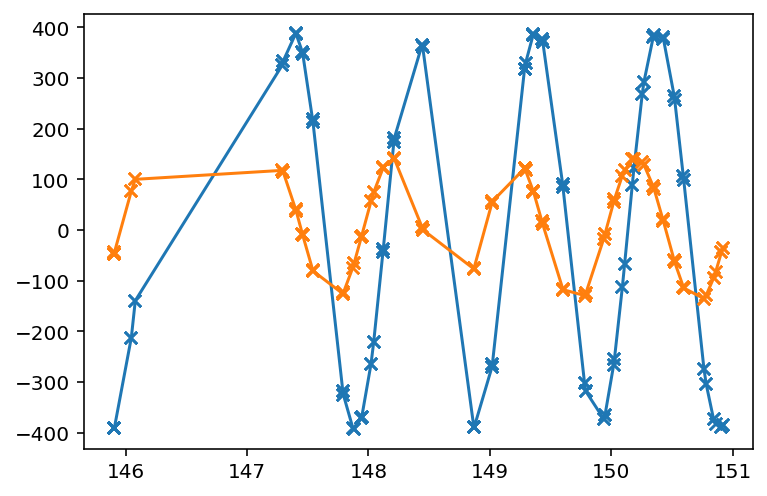

In [36]:
# we need the sorted-index array compute above
P.plot(psr.toas()[i]/365.25,d[i,1],'-x'); 
P.plot(psr.toas()[i]/365.25,d[i,2],'-x')

It's easy to save the current timing-model to a new par file. Omitting the argument will overwrite the original parfile.

In [37]:
psr.savepar('./foo.par')

In [38]:
!head foo.par

PSRJ           1909-3744
RAJ             19:09:47.4380323         1  0.00000763036274628952   
DECJ           -37:44:14.31899           1  0.00032627056123570196   
F0             339.31569275867968827     1  0.00000000000272673004   
F1             -1.6147963690678677477e-15 1  2.3035693452634613346e-20
PEPOCH         53000                       
POSEPOCH       53000                       
DMEPOCH        53000                       
DM             12.44929217501132257      1  2.44202771096587323285   
PMRA           -9.6113488454687274753    1  0.02203021686405922872   


Same for writing tim files.

In [39]:
psr.savetim('./foo.tim')

In [40]:
!head foo.tim

FORMAT 1
MODE 1
 53292.000004.1.000.000.tsum 1372.00000000 53292.01653552588140172 1.23100 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53292.000010.1.000.000.tsum 1372.00000000 53292.04810962983469835 4.66800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53355.000005.1.000.000.tsum 1372.00000000 53355.83359727578050169 0.45300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 1081.587 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53800.000018.1.000.000.tsum 1372.00000000 53800.48353665754979858 0.14800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3424.969 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53838.000020.1.000.000.tsum 1372.00000000 53838.37506136744340068 0.54300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3064.446 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53858.000028.1.000.000.tsum 1372.00000000 53858.31918408581089963 0.08900 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -to

With libstempo, it's easy to replicate some of the "toasim" plugin functionality. By subtracting the residuals from the site TOAs (psr.stoas, vs. the barycentered psr.toas) and refitting, we can create a "perfect" timing solution. (Note that 1 ns is roughly tempo2's claimed accuracy.)

In [41]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

1.7845169510588166


In [42]:
psr.stoas[:] -= psr.residuals() / 86400.0
ret = psr.fit(iters = 4)

In [43]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

0.001511491882618748


Then we can add, e.g., homoskedastic white measurement noise at 100 ns (remember the tempo units: days for TOAs, us for errors, s for residuals).

In [44]:
psr.stoas[:] += 0.1e-6 * N.random.randn(psr.nobs) / 86400.0
psr.toaerrs[:] = 0.1
ret = psr.fit()

<ErrorbarContainer object of 3 artists>

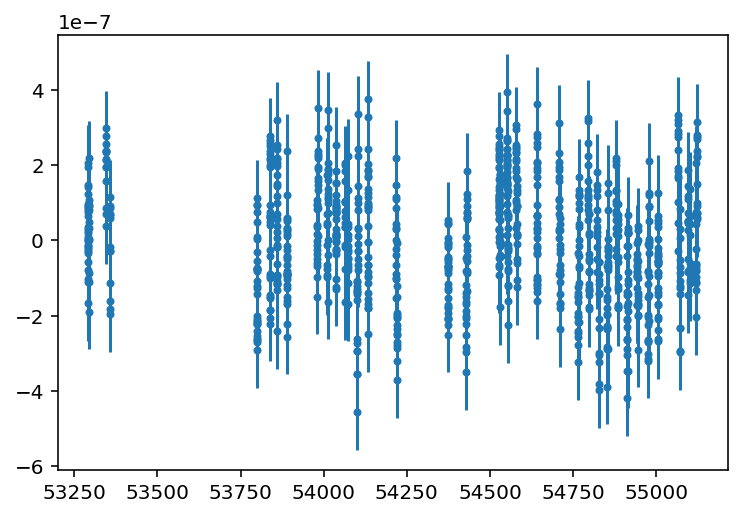

In [45]:
i = N.argsort(psr.toas())
P.errorbar(psr.toas()[i],psr.residuals()[i],yerr=1e-6*psr.toaerrs[i],fmt='.')